<a href="https://colab.research.google.com/github/LorenzoCausa/4519089_Causa/blob/main/ML_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORT

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from random import sample
from sklearn.svm import SVC
import math
from math import cos,sin,pi
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.kernel_ridge import KernelRidge as KRR


from MATRIX to RPY

In [83]:
def rotationMatrixToEulerAngles(R) :
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
    singular = sy < 1e-6
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
    return np.array([x, y, z])

FORWARD KINEMATIC

In [84]:
def dirKin(q1,q2,q3,q4,q5,q6):
  global angle_range
  l1=0.4
  l2=0.75
  l3=0.25

  d1=0.75
  d4=0.8124
  d6=0.175

  T01 = np.array( [ [cos(q1), 0,  sin(q1),  l1*cos(q1)],
                    [sin(q1), 0, -cos(q1),  l1*sin(q1)],
                    [0,       1,  0,         d1       ],
                    [0,       0,  0,         1        ]])

  T12 = np.array( [ [cos(q2), -sin(q2), 0, l2*cos(q2)],
                   [sin(q2), cos(q2),  0, l2*sin(q2)],
                   [0,       0,        1, 0         ],
                   [0,       0,        0, 1         ]])

  T23 = np.array( [ [cos(q3), 0,  sin(q3), l3*cos(q3) ],
                    [sin(q3), 0, -cos(q3), l3 *sin(q3)],
                    [0,       1,  0,       0          ],
                    [0,       0,  0,       1          ]])

  T34 = np.array( [ [cos(q4), 0, -sin(q4), 0  ],
                    [sin(q4), 0,  cos(q4), 0  ],
                    [0,      -1,  0,       d4 ],
                    [0,       0,  0,       1  ]])

  T45 = np.array( [ [cos(q5), 0, sin(q5),  0],
                    [sin(q5), 0, -cos(q5), 0],
                    [0,       1, 0,        0],
                    [0,       0, 0,        1]])

  T56 = np.array( [ [cos(q6), -sin(q6), 0, 0  ],
                    [sin(q6), cos(q6),  0, 0  ],
                    [0,       0,        1, d6 ],
                    [0,       0,        0, 1  ]])

  T06=np.matmul(np.matmul(np.matmul(np.matmul(np.matmul(T01,T12),T23),T34),T45),T56)

  rpy=rotationMatrixToEulerAngles(T06[0:3,0:3])
  xyz=T06[0:3,3]
  angle_range=pi/2 
  #print(T06)
  #print("-----------")
  #print("x,y,z positions: ",xyz)
  #print("r,p,y orientations: ",rpy)
  return np.concatenate((xyz, rpy), axis=0)
  

In [85]:
print("Test")
print(dirKin(0,pi/2,0,0,0,0))

Test
[ 1.3874      0.          1.75       -3.14159265 -1.57079633  0.        ]


GENERATE RANDOM DATASET

In [86]:
def generate_random_dataset():
    global q,xyz,xyzq1,xyzq1q2,xyzq1q2q3,xyzq1q2q3q4,xyzq1q2q3q4q5
    q=np.zeros((n,6))
    xyz=np.zeros((n,3))
    
    for i in range(n-1):
      q1=angle_range*random.random()-(pi/4)
      q[i,0]=q1
      q2=angle_range*random.random()
      q[i,1]=q2
      q3=angle_range*random.random()
      q[i,2]=q3
      q4=angle_range*random.random()
      q[i,3]=q4
      q5=angle_range*random.random()
      q[i,4]=q5
      q6=angle_range*random.random()
      q[i,5]=q6
    
      temp=dirKin(q1,q2,q3,q4,q5,q6)
      xyz[i,0]=temp[0]
      xyz[i,1]=temp[1]
      xyz[i,2]=temp[2]
    
    # Base configuration
    q1=0       
    q2=pi/2    
    q3=0      
    q4=0      
    q5=0       
    q6=0       
    q[n-1,0]=q1
    q[n-1,1]=q2
    q[n-1,2]=q3
    q[n-1,3]=q4
    q[n-1,4]=q5
    q[n-1,5]=q6
    
    temp=dirKin(q1,q2,q3,q4,q5,q6)
    xyz[n-1,0]=temp[0]
    xyz[n-1,1]=temp[1]
    xyz[n-1,2]=temp[2]
        
    temp=q[:,0].reshape(n,1)
    xyzq1=np.concatenate((xyz,temp),axis=1)  
    
    temp=q[:,0:2].reshape(n,2)
    xyzq1q2=np.concatenate((xyz,temp),axis=1)  
    
    temp=q[:,0:3].reshape(n,3)
    xyzq1q2q3=np.concatenate((xyz,temp),axis=1)   
    
    temp=q[:,0:4].reshape(n,4)
    xyzq1q2q3q4=np.concatenate((xyz,temp),axis=1)  
    
    temp=q[:,0:5].reshape(n,5)
    xyzq1q2q3q4q5=np.concatenate((xyz,temp),axis=1) 


In [87]:
def generate_validation_dataset():
    global q_validation,xyz_validation
    q_validation=np.zeros((n_validation,6))
    xyz_validation=np.zeros((n_validation,3))
    
    for i in range(n_validation):
      q1=angle_range*random.random()-(pi/4)
      q_validation[i,0]=q1
      q2=angle_range*random.random()
      q_validation[i,1]=q2
      q3=angle_range*random.random()
      q_validation[i,2]=q3
      q4=angle_range*random.random()
      q_validation[i,3]=q4
      q5=angle_range*random.random()
      q_validation[i,4]=q5
      q6=angle_range*random.random()
      q_validation[i,5]=q6
    
      temp=dirKin(q1,q2,q3,q4,q5,q6)
      xyz_validation[i,0]=temp[0]
      xyz_validation[i,1]=temp[1]
      xyz_validation[i,2]=temp[2]

In [88]:
def generate_random_test_dataset():
    global q_test,xyz_test
    q_test=np.zeros((n_test,6))
    xyz_test=np.zeros((n_test,3))
    
    for i in range(n_test):
      q1=angle_range*random.random()-(pi/4)
      q_test[i,0]=q1
      q2=angle_range*random.random()
      q_test[i,1]=q2
      q3=angle_range*random.random()
      q_test[i,2]=q3
      q4=angle_range*random.random()
      q_test[i,3]=q4
      q5=angle_range*random.random()
      q_test[i,4]=q5
      q6=angle_range*random.random()
      q_test[i,5]=q6
    
      temp=dirKin(q1,q2,q3,q4,q5,q6)
      xyz_test[i,0]=temp[0]
      xyz_test[i,1]=temp[1]
      xyz_test[i,2]=temp[2]

In [89]:
#print("Test")
#print(q)
#print('----------------')
#print(xyz)

RANDOM FOREST

In [90]:
def grid_search_random_forest():
    global H1,H2,H3,H4,H5,H6
    param_grid = { 
            "n_estimators"      : [100],
            "max_features"      : ["auto"],
            "min_samples_split" : [10],
            "bootstrap": [True, False],
            }
    MS1 = GridSearchCV(estimator = RandomForestRegressor(),param_grid = param_grid,cv=3)
    MS2 = GridSearchCV(estimator = RandomForestRegressor(),param_grid = param_grid,cv=3)
    MS3 = GridSearchCV(estimator = RandomForestRegressor(),param_grid = param_grid,cv=3)
    MS4 = GridSearchCV(estimator = RandomForestRegressor(),param_grid = param_grid,cv=3)
    MS5 = GridSearchCV(estimator = RandomForestRegressor(),param_grid = param_grid,cv=3)
    MS6 = GridSearchCV(estimator = RandomForestRegressor(),param_grid = param_grid,cv=3)
    
    H1 = MS1.fit(xyz,q[:,0])
    print("H1 ready")
    print(H1.best_params_)
    H2 = MS2.fit(xyzq1,q[:,1])
    print("H2 ready")
    print(H2.best_params_)
    H3 = MS3.fit(xyzq1q2,q[:,2])
    print("H3 ready")
    print(H3.best_params_)
    H4 = MS4.fit(xyzq1q2q3,q[:,3])
    print("H4 ready")
    print(H4.best_params_)
    H5 = MS5.fit(xyzq1q2q3q4,q[:,4])
    print("H5 ready")
    print(H5.best_params_)
    H6 = MS6.fit(xyzq1q2q3q4q5,q[:,5])
    print("H6 ready")
    print(H6.best_params_)

In [91]:
def train_random_forest():
    global M1,M2,M3,M4,M5,M6
    M1=RandomForestRegressor(bootstrap=H1.best_params_['bootstrap'],
                             max_features=H1.best_params_['max_features'],
                             n_estimators=H1.best_params_['n_estimators'],
                             min_samples_split=H1.best_params_['min_samples_split'],
                             )
    M2=RandomForestRegressor(bootstrap=H2.best_params_['bootstrap'],
                             max_features=H2.best_params_['max_features'],
                             n_estimators=H2.best_params_['n_estimators'],
                             min_samples_split=H2.best_params_['min_samples_split'],
                             )
    M3=RandomForestRegressor(bootstrap=H3.best_params_['bootstrap'],
                             max_features=H3.best_params_['max_features'],
                             n_estimators=H3.best_params_['n_estimators'],
                             min_samples_split=H3.best_params_['min_samples_split'],
                             )
    M4=RandomForestRegressor(bootstrap=H4.best_params_['bootstrap'],
                             max_features=H4.best_params_['max_features'],
                             n_estimators=H4.best_params_['n_estimators'],
                             min_samples_split=H4.best_params_['min_samples_split'],
                             )
    M5=RandomForestRegressor(bootstrap=H5.best_params_['bootstrap'],
                             max_features=H5.best_params_['max_features'],
                             n_estimators=H5.best_params_['n_estimators'],
                             min_samples_split=H5.best_params_['min_samples_split'],
                             )
    M6=RandomForestRegressor(bootstrap=H6.best_params_['bootstrap'],
                             max_features=H6.best_params_['max_features'],
                             n_estimators=H6.best_params_['n_estimators'],
                             min_samples_split=H6.best_params_['min_samples_split'],
                             )
    
    M1.fit(xyz,q[:,0])
    M2.fit(xyzq1,q[:,1])
    M3.fit(xyzq1q2,q[:,2])
    M4.fit(xyzq1q2q3,q[:,3])
    M5.fit(xyzq1q2q3q4,q[:,4])
    M6.fit(xyzq1q2q3q4q5,q[:,5])
    print("Training completed")

SVR

In [92]:
def grid_search_svr():
    
    global H1,H2,H3,H4,H5,H6
    param_grid = {'C':[100,1000,10000],
        'kernel':     ['rbf'],
        'gamma':      [ 'auto'],
        'epsilon':    [0.001,0.01]}
    MS1 = GridSearchCV(estimator = SVR(),param_grid = param_grid,cv=3)
    MS2 = GridSearchCV(estimator = SVR(),param_grid = param_grid,cv=3)
    MS3 = GridSearchCV(estimator = SVR(),param_grid = param_grid,cv=3)
    MS4 = GridSearchCV(estimator = SVR(),param_grid = param_grid,cv=3)
    MS5 = GridSearchCV(estimator = SVR(),param_grid = param_grid,cv=3)
    MS6 = GridSearchCV(estimator = SVR(),param_grid = param_grid,cv=3)
    
    H1 = MS1.fit(xyz,q[:,0])
    print("H1 ready")
    print(H1.best_params_)
    H2 = MS2.fit(xyzq1,q[:,1])
    print("H2 ready")
    print(H2.best_params_)
    H3 = MS3.fit(xyzq1q2,q[:,2])
    print("H3 ready")
    print(H3.best_params_)
    H4 = MS4.fit(xyzq1q2q3,q[:,3])
    print("H4 ready")
    print(H4.best_params_)
    H5 = MS5.fit(xyzq1q2q3q4,q[:,4])
    print("H5 ready")
    print(H5.best_params_)
    H6 = MS6.fit(xyzq1q2q3q4q5,q[:,5])
    print("H6 ready")
    print(H6.best_params_)

In [93]:
def train_SVR_grid_search_best():
    global M1,M2,M3,M4,M5,M6
    M1 = SVR(C = H1.best_params_['C'],
        kernel = H1.best_params_['kernel'],
        gamma = H1.best_params_['gamma'],
        epsilon = H1.best_params_['epsilon'])

    M2 = SVR(C = H2.best_params_['C'],
            kernel = H2.best_params_['kernel'],
            gamma = H2.best_params_['gamma'],
            epsilon = H2.best_params_['epsilon'])
    
    M3 = SVR(C = H3.best_params_['C'],
            kernel = H3.best_params_['kernel'],
            gamma = H3.best_params_['gamma'],
            epsilon = H3.best_params_['epsilon'])
    
    M4 = SVR(C = H4.best_params_['C'],
            kernel = H4.best_params_['kernel'],
            gamma = H4.best_params_['gamma'],
            epsilon = H4.best_params_['epsilon'])
    
    M5 = SVR(C = H5.best_params_['C'],
            kernel = H5.best_params_['kernel'],
            gamma = H5.best_params_['gamma'],
            epsilon = H5.best_params_['epsilon'])
    
    M6 = SVR(C = H6.best_params_['C'],
            kernel = H6.best_params_['kernel'],
            gamma = H6.best_params_['gamma'],
            epsilon = H6.best_params_['epsilon'])
    
    
    M1.fit(xyz,q[:,0])
    M2.fit(xyzq1,q[:,1])
    M3.fit(xyzq1q2,q[:,2])
    M4.fit(xyzq1q2q3,q[:,3])
    M5.fit(xyzq1q2q3q4,q[:,4])
    M6.fit(xyzq1q2q3q4q5,q[:,5])

In [94]:
def train_SVR_no_grid_search_best():
    global M1,M2,M3,M4,M5,M6
    Csvr=1000
    gammasvr=1
    epsilonsvr=0.01

    M1 = SVR(C = Csvr,
        kernel ='rbf',
        gamma = gammasvr,
        epsilon = epsilonsvr)

    M2 = SVR(C = Csvr,
            kernel ='rbf',
            gamma = gammasvr,
            epsilon = epsilonsvr)
    
    M3 = SVR(C = Csvr,
            kernel = 'rbf',
            gamma = gammasvr,
            epsilon = epsilonsvr)
    
    M4 = SVR(C = Csvr,
            kernel = 'rbf',
            gamma = gammasvr,
            epsilon = epsilonsvr)
    
    M5 = SVR(C = Csvr,
            kernel = 'rbf',
            gamma = gammasvr,
            epsilon = epsilonsvr)
    
    M6 = SVR(C = Csvr,
            kernel = 'rbf',
            gamma = gammasvr,
            epsilon = epsilonsvr)
    
    
    M1.fit(xyz,q[:,0])
    M2.fit(xyzq1,q[:,1])
    M3.fit(xyzq1q2,q[:,2])
    M4.fit(xyzq1q2q3,q[:,3])
    M5.fit(xyzq1q2q3q4,q[:,4])
    M6.fit(xyzq1q2q3q4q5,q[:,5])

In [95]:
def train_svr_with_param_val_on_xyz():
  global C_best,gamma_best,eps_best

  M1 = SVR(C = C_best,
        kernel = 'rbf',
        gamma = 'auto',
        epsilon = eps_best)

  M2 = SVR(C = C_best,
        kernel = 'rbf',
        gamma = 'auto',
        epsilon = eps_best)
    
  M3 = SVR(C = C_best,
        kernel ='rbf',
        gamma ='auto',
        epsilon = eps_best)
    
  M4 = SVR(C = C_best,
        kernel = 'rbf',
        gamma = 'auto',
        epsilon = eps_best)
    
  M5 = SVR(C = C_best,
        kernel = 'rbf',
        gamma = 'auto',
        epsilon = eps_best)
    
  M6 = SVR(C = C_best,
        kernel = 'rbf',
        gamma = 'auto',
        epsilon = eps_best)
    
    
  M1.fit(xyz,q[:,0])
  M2.fit(xyzq1,q[:,1])
  M3.fit(xyzq1q2,q[:,2])
  M4.fit(xyzq1q2q3,q[:,3])
  M5.fit(xyzq1q2q3q4,q[:,4])
  M6.fit(xyzq1q2q3q4q5,q[:,5])
  print("C: ",C_best," gamma: ",gamma_best," epsilon: ",eps_best)

In [96]:
def generate_model_with_validation_on_xyz():
    global M1,M2,M3,M4,M5,M6,C_best,gamma_best,eps_best
    C_arr=[10,100,1000]
    eps_arr=[0.001,0.01]
    gamma_arr= [ 1,0.01]
    
    C_best=0
    gamma_best=0
    eps_best=0
    
    
    e_tot_min=1000
    for ic in range(len(C_arr)):
        for ie in range(len(eps_arr)):
            for ig in range(len(gamma_arr)):
                M1 = SVR(C = C_arr[ic],
                        kernel = 'rbf',
                        gamma = gamma_arr[ig],
                        epsilon = eps_arr[ie])
                M2 = SVR(C = C_arr[ic],
                        kernel = 'rbf',
                        gamma = gamma_arr[ig],
                        epsilon = eps_arr[ie])
                M3 = SVR(C = C_arr[ic],
                        kernel = 'rbf',
                        gamma = gamma_arr[ig],
                        epsilon = eps_arr[ie])
                M4 = SVR(C = C_arr[ic],
                        kernel = 'rbf',
                        gamma = gamma_arr[ig],
                        epsilon = eps_arr[ie])
                M5 = SVR(C = C_arr[ic],
                        kernel = 'rbf',
                        gamma = gamma_arr[ig],
                        epsilon = eps_arr[ie])
                M6 = SVR(C = C_arr[ic],
                        kernel = 'rbf',
                        gamma = gamma_arr[ig],
                        epsilon = eps_arr[ie])
                M1.fit(xyz,q[:,0])
                M2.fit(xyzq1,q[:,1])
                M3.fit(xyzq1q2,q[:,2])
                M4.fit(xyzq1q2q3,q[:,3])
                M5.fit(xyzq1q2q3q4,q[:,4])
                M6.fit(xyzq1q2q3q4q5,q[:,5])
                
                ex_tot=0
                ex=0
                
                ey_tot=0
                ey=0
                
                ez_tot=0
                ez=0
                
                XYZ_predictions=np.zeros((n_validation,3))
                
                for i in range(n_validation):
                  
                  q_pred=predict(xyz_validation[i,:].reshape(1,-1))
                  xyz_pred=dirKin(q_pred[0],q_pred[1],q_pred[2],q_pred[3],q_pred[4],q_pred[5])
                  xyz_pred=xyz_pred[0:3]
                  #XYZ_predictions[i,0]=xyz_pred[0]
                  #XYZ_predictions[i,1]=xyz_pred[1]
                  #XYZ_predictions[i,2]=xyz_pred[2]
                
                  ex=math.sqrt((xyz_pred[0]-xyz_validation[i,0])*(xyz_pred[0]-xyz_validation[i,0]))
                  ey=math.sqrt((xyz_pred[1]-xyz_validation[i,1])*(xyz_pred[1]-xyz_validation[i,1]))
                  ez=math.sqrt((xyz_pred[2]-xyz_validation[i,2])*(xyz_pred[2]-xyz_validation[i,2]))
                
                  ex_tot=ex_tot+ex
                  ey_tot=ey_tot+ey
                  ez_tot=ez_tot+ez
                
                  #print('xyz from predicted q: ',xyz_pred)
                  #print('target xyz: ',xyz_test[i,:])
                  #print('errors',ex,ey,ez)
                  #print('-------------------------------------')
                
                
                ex_mean=(ex_tot/n_validation)*1000
                ey_mean=(ey_tot/n_validation)*1000
                ez_mean=(ez_tot/n_validation)*1000
                e_tot=(ex_mean+ey_mean+ez_mean)/3
                
                print('error: ',round(e_tot,3)," mm  C:",C_arr[ic],"gammma:",gamma_arr[ig],"epsilon:",eps_arr[ie])
                
                if(e_tot<e_tot_min):
                    e_tot_min=e_tot
                    print("\n e_totMin:",e_tot_min)
                    gamma_best=gamma_arr[ig]
                    C_best=C_arr[ic]
                    eps_best=eps_arr[ie]
                    print("gamma best:",gamma_best)
                    print("epsilon best:",eps_best)
                    print("C best:",C_best)
    
    print("\n e_totMin:",e_tot_min)

In [97]:
def grid_search_svr_only_xyz():
    
    global H1,H2,H3,H4,H5,H6
    param_grid = {'C':[10,100,1000],
        'kernel':     ['rbf'],
        'gamma':       [ 1,0.1,0.01],
        'epsilon':    [0.001,0.01]}
    MS1 = GridSearchCV(estimator = SVR(),param_grid = param_grid,cv=3)
    MS2 = GridSearchCV(estimator = SVR(),param_grid = param_grid,cv=3)
    MS3 = GridSearchCV(estimator = SVR(),param_grid = param_grid,cv=3)
    MS4 = GridSearchCV(estimator = SVR(),param_grid = param_grid,cv=3)
    MS5 = GridSearchCV(estimator = SVR(),param_grid = param_grid,cv=3)
    MS6 = GridSearchCV(estimator = SVR(),param_grid = param_grid,cv=3)
    
    H1 = MS1.fit(xyz,q[:,0])
    print("H1 ready")
    print(H1.best_params_)
    H2 = MS2.fit(xyz,q[:,1])
    print("H2 ready")
    print(H2.best_params_)
    H3 = MS3.fit(xyz,q[:,2])
    print("H3 ready")
    print(H3.best_params_)
    H4 = MS4.fit(xyz,q[:,3])
    print("H4 ready")
    print(H4.best_params_)
    H5 = MS5.fit(xyz,q[:,4])
    print("H5 ready")
    print(H5.best_params_)
    H6 = MS6.fit(xyz,q[:,5])
    print("H6 ready")
    print(H6.best_params_)

In [98]:
def train_SVR_grid_search_best_only_xyz():
    global M1,M2,M3,M4,M5,M6
    M1 = SVR(C = H1.best_params_['C'],
        kernel = H1.best_params_['kernel'],
        gamma = H1.best_params_['gamma'],
        epsilon = H1.best_params_['epsilon'])

    M2 = SVR(C = H2.best_params_['C'],
            kernel = H2.best_params_['kernel'],
            gamma = H2.best_params_['gamma'],
            epsilon = H2.best_params_['epsilon'])
    
    M3 = SVR(C = H3.best_params_['C'],
            kernel = H3.best_params_['kernel'],
            gamma = H3.best_params_['gamma'],
            epsilon = H3.best_params_['epsilon'])
    
    M4 = SVR(C = H4.best_params_['C'],
            kernel = H4.best_params_['kernel'],
            gamma = H4.best_params_['gamma'],
            epsilon = H4.best_params_['epsilon'])
    
    M5 = SVR(C = H5.best_params_['C'],
            kernel = H5.best_params_['kernel'],
            gamma = H5.best_params_['gamma'],
            epsilon = H5.best_params_['epsilon'])
    
    M6 = SVR(C = H6.best_params_['C'],
            kernel = H6.best_params_['kernel'],
            gamma = H6.best_params_['gamma'],
            epsilon = H6.best_params_['epsilon'])
    
    
    M1.fit(xyz,q[:,0])
    M2.fit(xyz,q[:,1])
    M3.fit(xyz,q[:,2])
    M4.fit(xyz,q[:,3])
    M5.fit(xyz,q[:,4])
    M6.fit(xyz,q[:,5])

MEAN ERROR

In [99]:
def predict(xyz_target):
  q_pred1 = M1.predict(xyz_target)
  xyzq1_target=np.concatenate((xyz_target,q_pred1.reshape(1, -1)),axis=1)

  q_pred2 = M2.predict(xyzq1_target)
  xyzq1q2_target=np.concatenate((xyzq1_target,q_pred2.reshape(1, -1)),axis=1)

  q_pred3 = M3.predict(xyzq1q2_target)
  xyzq1q2q3_target=np.concatenate((xyzq1q2_target,q_pred3.reshape(1, -1)),axis=1)

  q_pred4 = M4.predict(xyzq1q2q3_target)
  xyzq1q2q3q4_target=np.concatenate((xyzq1q2q3_target,q_pred4.reshape(1, -1)),axis=1)

  q_pred5 = M5.predict(xyzq1q2q3q4_target)
  xyzq1q2q3q4q5_target=np.concatenate((xyzq1q2q3q4_target,q_pred5.reshape(1, -1)),axis=1)

  q_pred6 = M6.predict(xyzq1q2q3q4q5_target)

  #pred_xyz=dirKin(q_pred1,q_pred2,q_pred3,q_pred4,q_pred5,q_pred6)
  #print('q pred: ',q_pred1,q_pred2,q_pred3,q_pred4,q_pred5,q_pred6)
  #print('target forward kinematics :',xyz_target)
  #print('pred forward kinematics :',pred_xyz[0:3])
  all_q = np.array([q_pred1,q_pred2,q_pred3,q_pred4,q_pred5,q_pred6])
  return all_q

In [100]:
def compute_mean_error():
    
    global XYZ_predictions
    ex_tot=0
    ex=0
    
    ey_tot=0
    ey=0
    
    ez_tot=0
    ez=0
    
    XYZ_predictions=np.zeros((n_test,3))
    
    for i in range(n_test):
      
      #if i%(n_test/10)==0 and i!=0:
      #    print(i*10/(n_test/10),"% completed")
      q_pred=predict(xyz_test[i,:].reshape(1,-1))
      xyz_pred=dirKin(q_pred[0],q_pred[1],q_pred[2],q_pred[3],q_pred[4],q_pred[5])
      xyz_pred=xyz_pred[0:3]
      XYZ_predictions[i,0]=xyz_pred[0]
      XYZ_predictions[i,1]=xyz_pred[1]
      XYZ_predictions[i,2]=xyz_pred[2]
    
      ex=math.sqrt((xyz_pred[0]-xyz_test[i,0])*(xyz_pred[0]-xyz_test[i,0]))
      ey=math.sqrt((xyz_pred[1]-xyz_test[i,1])*(xyz_pred[1]-xyz_test[i,1]))
      ez=math.sqrt((xyz_pred[2]-xyz_test[i,2])*(xyz_pred[2]-xyz_test[i,2]))
    
      ex_tot=ex_tot+ex
      ey_tot=ey_tot+ey
      ez_tot=ez_tot+ez

      #print('xyz from predicted q: ',xyz_pred)
      #print('target xyz: ',xyz_test[i,:])
      #print('errors',ex,ey,ez)
      #print('-------------------------------------')
    
    
    ex_mean=(ex_tot/n_test)*1000
    ey_mean=(ey_tot/n_test)*1000
    ez_mean=(ez_tot/n_test)*1000
    e_tot=(ex_mean+ey_mean+ez_mean)/3
    
    print('mean error along x: ',math.trunc(ex_mean)," mm")
    print('mean error along y: ',math.trunc(ey_mean)," mm")
    print('mean error along z: ',math.trunc(ez_mean)," mm")
    print('\n\nmean error tot: ',round(e_tot,3)," mm")

In [101]:
def compute_mean_error_on_q():
    
    XYZ_predictions=np.zeros((n_test,3))
    err_vect=np.zeros((6,1))
    for i in range(n_test):
        
      q_test_t=q_test[i,:].reshape(-1,1)
      
      
      #if i%(n_test/10)==0 and i!=0:
      #    print(i*10/(n_test/10),"% completed")
      q_pred=predict(xyz_test[i,:].reshape(1,-1))
      err_vect=err_vect+np.abs(q_pred-q_test_t)
    
    #print("q_pred",q_pred)
    #print("q_test",q_test_t)
    #print("difference",q_pred-q_test_t)
    #print("abs",np.abs(q_pred-q_test_t))
    #print(q_test_t)
    #print("err_vect: ",(err_vect*180)/pi)
    err_mean=err_vect/n_test
    
    print('mean error for each q\n: ',(err_mean*180)/pi,"deg\n")
    err_mean=err_mean[0:5]
    print("total mean \n",(np.mean(err_mean)*180)/pi,"deg\n")

In [102]:
def find_big_error_q_small_xyz():
    
    XYZ_predictions=np.zeros((n_test,3))
    err_vect=np.zeros((6,1))
    for i in range(n_test):
      q_pred=predict(xyz_test[i,:].reshape(1,-1))
      xyz_pred=dirKin(q_pred[0],q_pred[1],q_pred[2],q_pred[3],q_pred[4],q_pred[5])
      xyz_pred=xyz_pred[0:3]
    
      ex=math.sqrt((xyz_pred[0]-xyz_test[i,0])*(xyz_pred[0]-xyz_test[i,0]))
      ey=math.sqrt((xyz_pred[1]-xyz_test[i,1])*(xyz_pred[1]-xyz_test[i,1]))
      ez=math.sqrt((xyz_pred[2]-xyz_test[i,2])*(xyz_pred[2]-xyz_test[i,2]))  
      q_test_t=q_test[i,:].reshape(-1,1)
      e_t=(ex+ey+ez)/3
      
      
      err_vect_q=np.abs(q_pred-q_test_t)

      err_mean_q=np.mean(err_vect_q[0:5])

      if(e_t*1000<10 and err_mean_q>0.5):
          print("xyz test set: ",xyz_test[i,:].reshape(1,-1))
          print("xyz predicted: ",xyz_pred)
          print("q test set: ",q_test_t)
          print("q predicted: ",q_pred)
          print("errore su xyz: ",e_t)
          print("errore su q: ",err_mean_q)

    #print("q_pred",q_pred)
    #print("q_test",q_test_t)
    #print("difference",q_pred-q_test_t)
    #print("abs",np.abs(q_pred-q_test_t))
    #print(q_test_t)
    #print("err_vect: ",(err_vect*180)/pi)
    err_mean=err_vect/n_test
    
    print('mean error for each q\n: ',(err_mean*180)/pi,"deg\n")
    err_mean=err_mean[0:5]
    print("total mean \n",(np.mean(err_mean)*180)/pi,"deg\n")

In [103]:
def predict_only_xyz(xyz_target):
  q_pred1 = M1.predict(xyz_target)

  q_pred2 = M2.predict(xyz_target)

  q_pred3 = M3.predict(xyz_target)

  q_pred4 = M4.predict(xyz_target)

  q_pred5 = M5.predict(xyz_target)

  q_pred6 = M6.predict(xyz_target)

  #pred_xyz=dirKin(q_pred1,q_pred2,q_pred3,q_pred4,q_pred5,q_pred6)
  #print('q pred: ',q_pred1,q_pred2,q_pred3,q_pred4,q_pred5,q_pred6)
  #print('target forward kinematics :',xyz_target)
  #print('pred forward kinematics :',pred_xyz[0:3])
  all_q = np.array([q_pred1,q_pred2,q_pred3,q_pred4,q_pred5,q_pred6])
  return all_q

def compute_mean_error_only_xyz():
    
    global XYZ_predictions
    ex_tot=0
    ex=0
    
    ey_tot=0
    ey=0
    
    ez_tot=0
    ez=0
    
    XYZ_predictions=np.zeros((n_test,3))
    
    for i in range(n_test):
      
      #if i%(n_test/10)==0 and i!=0:
      #    print(i*10/(n_test/10),"% completed")

      q_pred=predict_only_xyz(xyz_test[i,:].reshape(1,-1))
      xyz_pred=dirKin(q_pred[0],q_pred[1],q_pred[2],q_pred[3],q_pred[4],q_pred[5])
      xyz_pred=xyz_pred[0:3]
      XYZ_predictions[i,0]=xyz_pred[0]
      XYZ_predictions[i,1]=xyz_pred[1]
      XYZ_predictions[i,2]=xyz_pred[2]
    
      ex=math.sqrt((xyz_pred[0]-xyz_test[i,0])*(xyz_pred[0]-xyz_test[i,0]))
      ey=math.sqrt((xyz_pred[1]-xyz_test[i,1])*(xyz_pred[1]-xyz_test[i,1]))
      ez=math.sqrt((xyz_pred[2]-xyz_test[i,2])*(xyz_pred[2]-xyz_test[i,2]))
    
      ex_tot=ex_tot+ex
      ey_tot=ey_tot+ey
      ez_tot=ez_tot+ez
    
      #print('xyz from predicted q: ',xyz_pred)
      #print('target xyz: ',xyz_test[i,:])
      #print('errors',ex,ey,ez)
      #print('-------------------------------------')
    
    
    ex_mean=(ex_tot/n_test)*1000
    ey_mean=(ey_tot/n_test)*1000
    ez_mean=(ez_tot/n_test)*1000
    e_tot=(ex_mean+ey_mean+ez_mean)/3
    
    print('mean error along x: ',math.trunc(ex_mean)," mm")
    print('mean error along y: ',math.trunc(ey_mean)," mm")
    print('mean error along z: ',math.trunc(ez_mean)," mm")
    print('\n\nmean error tot: ',round(e_tot,3)," mm")



PLOT

In [104]:
def plot():
    
    fig, ax1 = plt.subplots()
    ax1.plot(XYZ_predictions[:,0],xyz_test[:,0],'bo')
    ax1.plot([np.min(xyz_test[:,0]),np.max(xyz_test[:,0])],[np.min(xyz_test[:,0]),np.max(xyz_test[:,0])],'r')
    ax1.set_title('X ERRORS')
    
    fig2, ax2 = plt.subplots()
    ax2.plot(XYZ_predictions[:,1],xyz_test[:,1],'bo')
    ax2.plot([np.min(xyz_test[:,1]),np.max(xyz_test[:,1])],[np.min(xyz_test[:,1]),np.max(xyz_test[:,1])],'r')
    ax2.set_title('Y ERRORS')
    
    fig3, ax3 = plt.subplots()
    ax3.plot(XYZ_predictions[:,2],xyz_test[:,2],'bo')
    ax3.plot([np.min(xyz_test[:,2]),np.max(xyz_test[:,2])],[np.min(xyz_test[:,2]),np.max(xyz_test[:,2])],'r')
    ax3.set_title('Z ERRORS')

MAIN

SVR validation with no grid search
mean error for each q
:  [[ 1.71153257]
 [ 6.33690786]
 [ 9.56663852]
 [29.0661322 ]
 [21.04847359]
 [41.12312185]] deg

total mean 
 13.545936948653585 deg

mean error along x:  12  mm
mean error along y:  15  mm
mean error along z:  16  mm


mean error tot:  14.855  mm


'\nprint("SVR only xyz")\ngrid_search_svr_only_xyz()\ntrain_SVR_grid_search_best_only_xyz()\ncompute_mean_error_only_xyz()\nplot()\n'

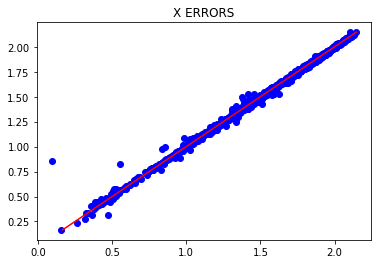

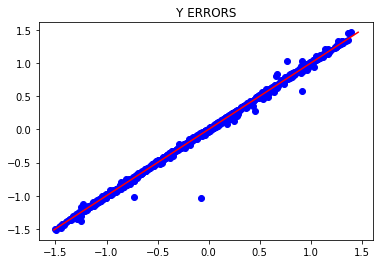

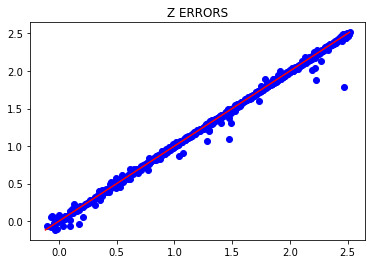

In [114]:

n=500
n_test=1000
n_validation=1000
generate_random_dataset()
generate_validation_dataset()
generate_random_test_dataset()

"""
print("random forest validation with grid search")
grid_search_random_forest()
train_random_forest()
compute_mean_error()
plot()


print("SVR validation on X,Y,Z")
generate_model_with_validation_on_xyz()
train_svr_with_param_val_on_xyz()
compute_mean_error_on_q()
compute_mean_error()
plot()


print("SVR validation with grid search")
grid_search_svr()
train_SVR_grid_search_best()
compute_mean_error_on_q()
compute_mean_error()
plot()

"""
print("SVR validation with no grid search")
train_SVR_no_grid_search_best()
compute_mean_error_on_q()
compute_mean_error()
plot()

"""
print("SVR only xyz")
grid_search_svr_only_xyz()
train_SVR_grid_search_best_only_xyz()
compute_mean_error_only_xyz()
plot()
"""

In [106]:
xyz=dirKin(pi/4, pi/2, pi/4, pi/4,  pi/4, 0)


print("starting q: ",pi/4, pi/2, pi/4, pi/4,  pi/4, 0)

#xyz=np.array([0.57429862, 1.18955221, 2.14162853])
print("xyz target: ",xyz)

q_pred=predict(xyz[0:3].reshape(1,-1))

xyz_pred=dirKin(q_pred[0],q_pred[1],q_pred[2],q_pred[3],q_pred[4],q_pred[5])

xyz_pred=xyz_pred[0:3]
print("q predicted", q_pred.reshape(1,-1))
print("xyz predicted", xyz_pred)
print("error: ",(xyz_pred-xyz[0:3])*1000)


starting q:  0.7853981633974483 1.5707963267948966 0.7853981633974483 0.7853981633974483 0.7853981633974483 0
xyz target:  [ 0.6440364   0.52029271  2.40060209 -0.52990279  0.14697519 -1.8262917 ]
q predicted [[ 0.68171501  0.90820816  1.15308547 -4.43544474  0.2856239   0.85017234]]
xyz predicted [1.28367727 0.9806261  2.0117241 ]
error:  [ 639.64087406  460.33338483 -388.87798669]


mean error along x:  74  mm
mean error along y:  56  mm
mean error along z:  97  mm


mean error tot:  76.358  mm


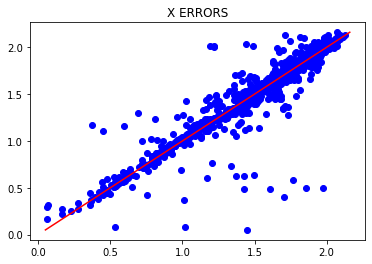

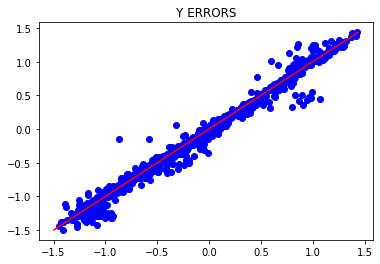

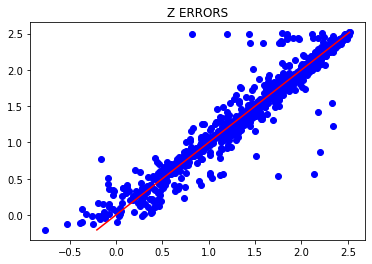

In [107]:
generate_random_test_dataset()
compute_mean_error()
plot()